References

- https://www.visgraf.impa.br/Courses/ip00/proj/Dithering1/floyd_steinberg_dithering.html
- https://en.wikipedia.org/wiki/Floyd%E2%80%93Steinberg_dithering


In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from PIL import Image
import io
from IPython.display import display

In [34]:
# Option 1: Load an image from file
def load_image_from_file(file_path):
    """Load and display an image from a file path"""
    # Load the image
    img = mpimg.imread(file_path)
    
    # Display the image
    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.title(f'Image: {file_path}')
    plt.show()
    
    return img

# Option 2: Upload an image interactively in Jupyter
def upload_image():
    """
    Upload and display an image interactively in Jupyter.
    
    Returns:
        function: A function that when called returns the uploaded image as a numpy array
                 with shape (height, width, channels) or None if no image was uploaded.
    """
    import ipywidgets as widgets
    
    # Create a variable to store our image data
    img_array = None
    
    uploader = widgets.FileUpload(
        accept='.png',
        multiple=False,
        description='Upload PNG Image'
    )
    display(uploader)
    
    def on_upload_change(change):
        nonlocal img_array
        if change['type'] == 'change' and change['name'] == 'value':
            # Get the uploaded file content
            if not uploader.value:  # Check if any files were uploaded
                img_array = None
                return
                
            # Access the first uploaded file
            uploaded_file = uploader.value[0]
            img_data = uploaded_file.content
            
            # Convert to PIL Image
            img = Image.open(io.BytesIO(img_data))
            
            # Convert to numpy array and store
            img_array = np.array(img)
            
            # Display the image
            plt.figure(figsize=(10, 8))
            plt.imshow(img_array)
            plt.axis('off')
            plt.title('Uploaded Image')
            plt.show()
    
    uploader.observe(on_upload_change, names='value')
    
    # Return a function that gives access to the image array
    def get_image():
        return img_array
    
    return get_image

def convert_to_grayscale(image_array):
    """
    Convert an RGB image array to grayscale using PIL.
    
    Args:
        image_array: Numpy array of the image
        
    Returns:
        Numpy array of the grayscale image
    """
    if image_array is None:
        print("No image data provided")
        return None
    
    # Convert to PIL Image
    img = Image.fromarray(image_array)
    
    # Convert to grayscale
    grayscale_img = img.convert('L')
    
    # Convert back to numpy array
    grayscale_array = np.array(grayscale_img)
    
    return grayscale_array

FileUpload(value=(), accept='.png', description='Upload PNG Image')

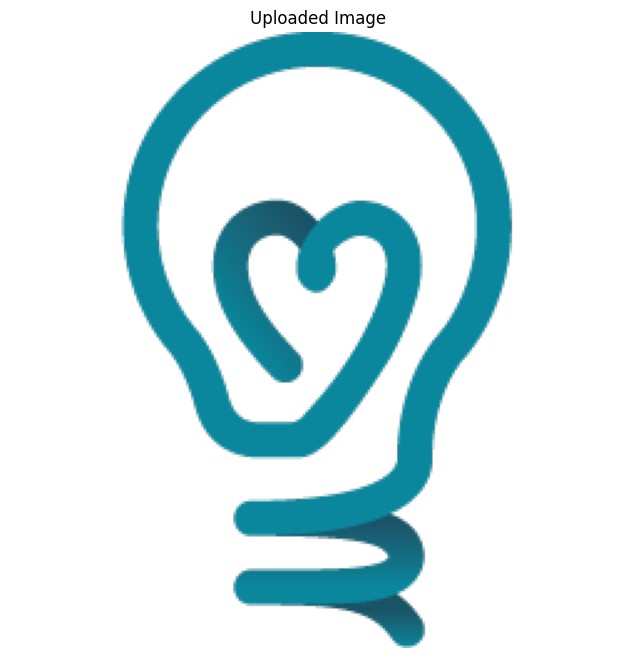

In [32]:
# 1. Load from file: img = load_image_from_file('path/to/your/image.png')
# 2. Upload interactively: upload_image()

get_image = upload_image()

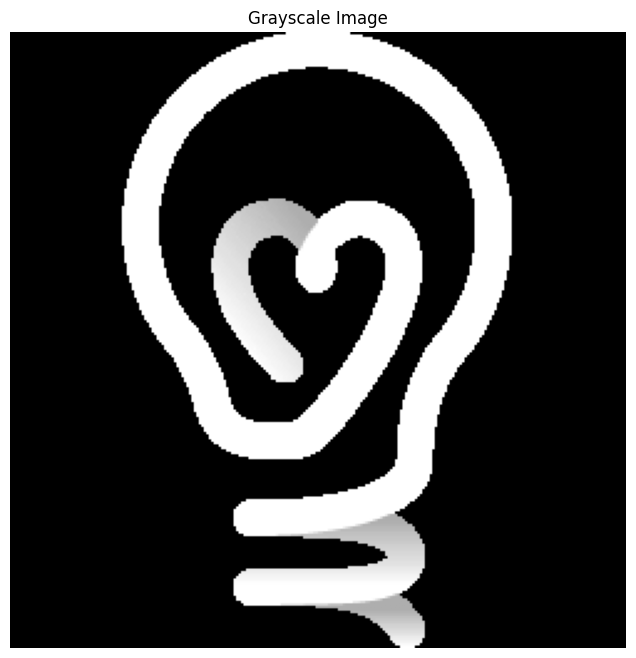

(248, 248)


In [51]:
image_pixels = get_image()

# Convert to grayscale
if image_pixels is not None:
    grayscale_pixels = convert_to_grayscale(image_pixels)
    
    # Display the grayscale image
    plt.figure(figsize=(10, 8))
    plt.imshow(grayscale_pixels, cmap='gray')
    plt.axis('off')
    plt.title('Grayscale Image')
    plt.show()
    
    # Update image_pixels to grayscale for further processing
    image_pixels = grayscale_pixels
else:
    print("No image has been uploaded yet.")

height, width = image_pixels.shape
print(image_pixels.shape)

In [78]:
# # Floyd-Steinberg Dithering Algorithm
# 
# This algorithm processes each pixel in the image and applies error diffusion dithering:
# 
# 1. For each pixel, find the closest available color in our palette
# 2. Replace the current pixel with that color
# 3. Compute the quantization error (difference between original and new color)
# 4. Distribute this error to neighboring pixels that haven't been processed yet
# 
# The error distribution follows this pattern:
# 
# ```
#       X   7/16
# 3/16 5/16 1/16
# ```
# 
# Where X is the current pixel, and the fractions represent how the error is distributed.
# This creates the illusion of more colors and reduces color banding.

def find_closest_palette_color(pixel):
    # For 10 evenly spaced values between 0-255
    step = 255 / 9  # Size of each step
    
    # Calculate index 
    index = round(pixel / step)
    
    # Clamp to valid range (0-9) and convert back to pixel value
    index = max(0, min(9, index))
    return index * step
    
    


pixels_copy = image_pixels.astype(float).copy()

for h in range(height):
    for w in range(width):
        old_pixel = pixels_copy[h][w]
        new_pixel = find_closest_palette_color(old_pixel)
        pixels_copy[h][w] = new_pixel
        quant_error = old_pixel - new_pixel
        
        # Distribute error to neighboring pixels
        if w + 1 < width:
            pixels_copy[h][w+1] += quant_error * 7/16
        if w - 1 >= 0 and h + 1 < height:
            pixels_copy[h+1][w-1] += quant_error * 3/16
        if h + 1 < height:
            pixels_copy[h+1][w] += quant_error * 5/16
        if w + 1 < width and h + 1 < height:
            pixels_copy[h+1][w+1] += quant_error * 1/16


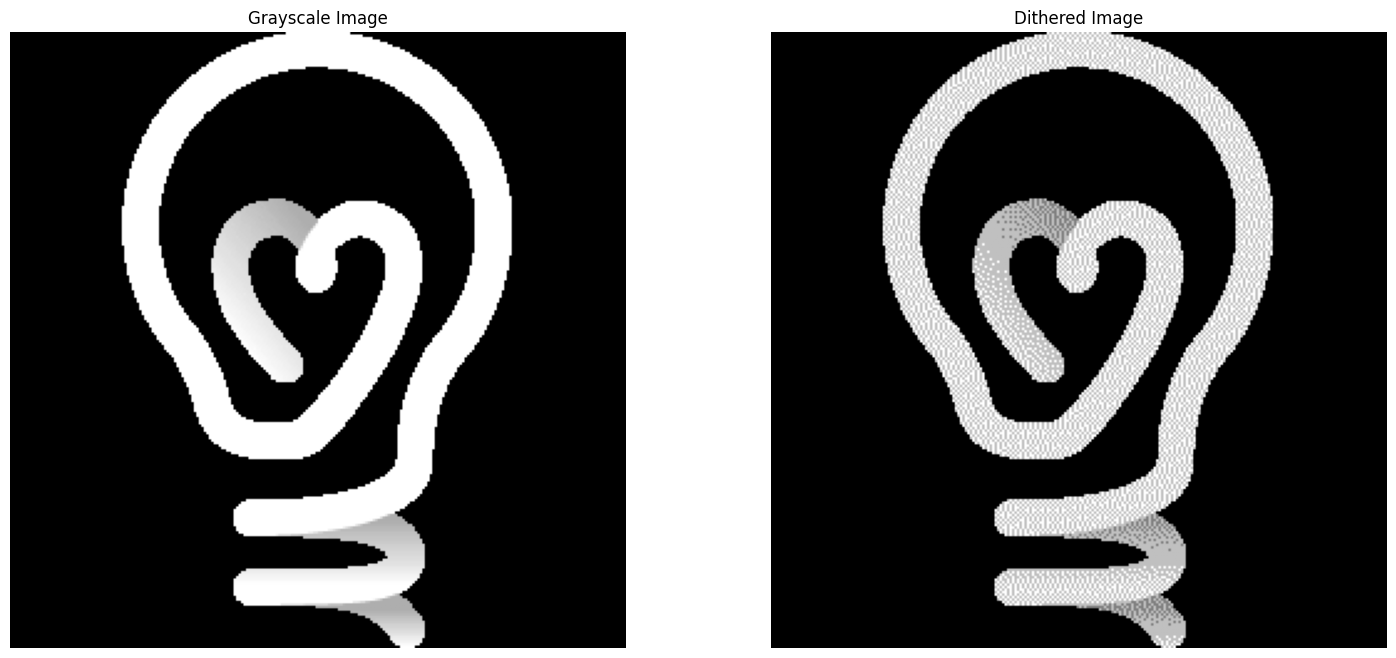

In [79]:
# Compare the images side by side
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
axes[0].imshow(image_pixels, cmap='gray')
axes[0].set_title('Grayscale Image')
axes[0].axis('off')
axes[1].imshow(pixels_copy, cmap='gray')
axes[1].set_title('Dithered Image')
axes[1].axis('off')
plt.show()

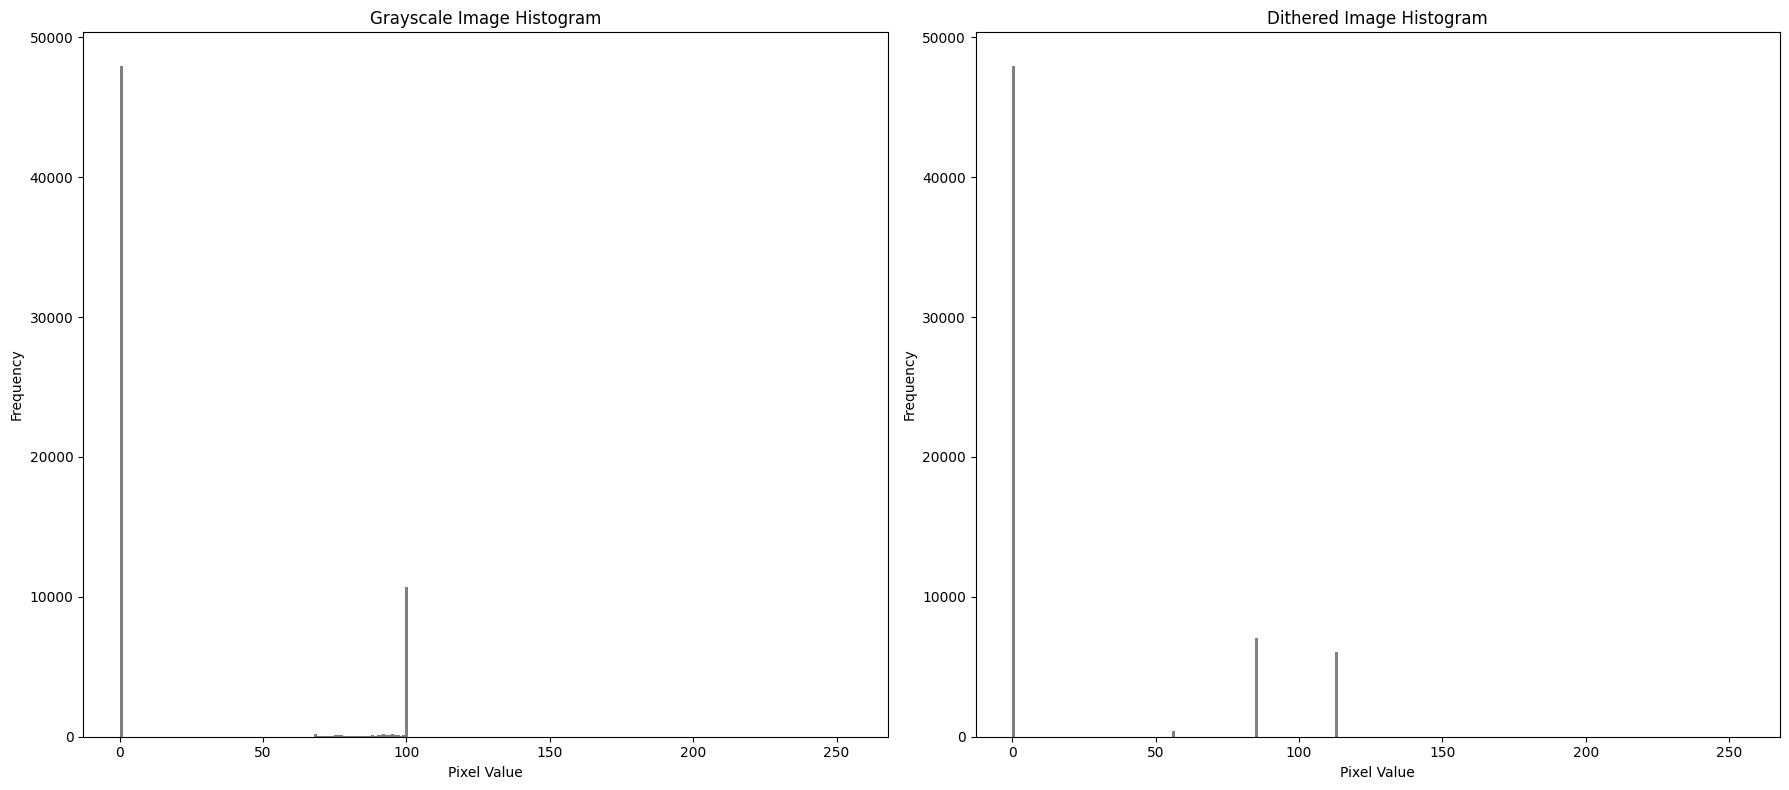

In [87]:
# Pretty plot distribution of pixels between the two images
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
axes[0].hist(image_pixels.flatten(), bins=256, range=(0, 255), color='gray')
axes[0].set_title('Grayscale Image Histogram')
axes[0].set_xlabel('Pixel Value')
axes[0].set_ylabel('Frequency')
axes[1].hist(pixels_copy.flatten(), bins=256, range=(0, 255), color='gray')
axes[1].set_title('Dithered Image Histogram')
axes[1].set_xlabel('Pixel Value')
axes[1].set_ylabel('Frequency')
plt.tight_layout()

In [ ]:
# TODO: Above: update the algorithm to use more shades


In [88]:
# Convert pixels_copy to a 1-d array
pixels_copy_flat = pixels_copy.flatten().astype(int)

# Convert the 1-d array to a number. Where the 1st value is the most significant bit.
# The last value is the least significant bit.

def large_array_to_int(arr, chunk_size=1000):
    # Process in manageable chunks
    result = 0
    for i in range(0, len(arr), chunk_size):
        chunk = arr[i:i+chunk_size]
        chunk_val = int(''.join(map(str, chunk)))
        # Shift previous result and add new chunk
        result = result * (10**len(chunk)) + chunk_val
    return result

number = large_array_to_int(pixels_copy_flat)

# Save to file without string conversion
with open("large_number.txt", "w") as f:
    remaining = number
    while remaining > 0:
        chunk = remaining % 10**9  # Process 9 digits at a time
        f.write(str(chunk).zfill(9))
        remaining //= 10**9


In [89]:
import gmpy2

# Load the number from file
number = gmpy2.mpz(open("large_number.txt", "r").read())

# Check if the number is prime
is_prime = gmpy2.is_prime(number)
print(f"Is the number prime? {is_prime}")

Is the number prime? False
